# Feux de forêt

Projet Python de 2A à l'ENSAE portant sur l'étude des feux de forêt en France.

# II. Analyse descriptive et représentation graphique

In [130]:
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
        zip_ref.extractall(dirname + '/' + destname)

In [132]:
download_unzip("https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12")
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


<AxesSubplot:>

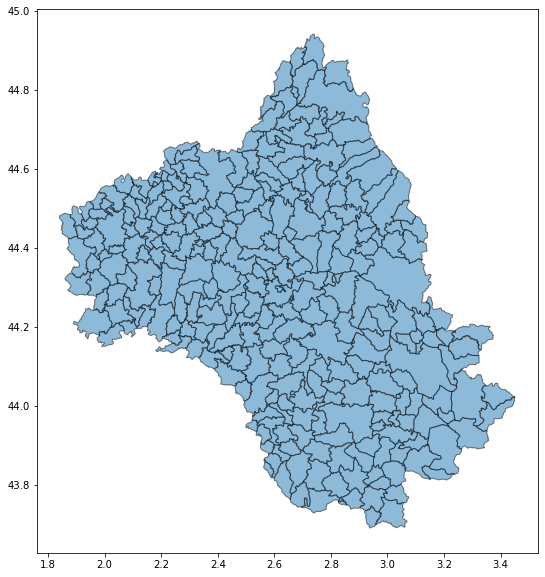

In [133]:
aveyron = communes[communes.insee.str.startswith("12")]
aveyron.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [134]:
communes['dep'] = communes['insee'].str[:2]

In [135]:
stations_geo = gpd.read_file('postesSynop.json')
stations_geo

,ID,Nom,Latitude,Longitude,Altitude,geometry
0,07005,ABBEVILLE,50.136000,1.834000,69,POINT (1.83400 50.13600)
1,07015,LILLE-LESQUIN,50.570000,3.097500,47,POINT (3.09750 50.57000)
2,07020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
3,07027,CAEN-CARPIQUET,49.180000,-0.456167,67,POINT (-0.45617 49.18000)
4,07037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.38300)
...,...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5,POINT (-54.03167 5.48550)
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4,POINT (-52.36533 4.82233)
59,81408,SAINT GEORGES,3.890667,-51.804667,6,POINT (-51.80467 3.89067)
60,81415,MARIPASOULA,3.640167,-54.028333,106,POINT (-54.02833 3.64017)


(40.0, 52.0)

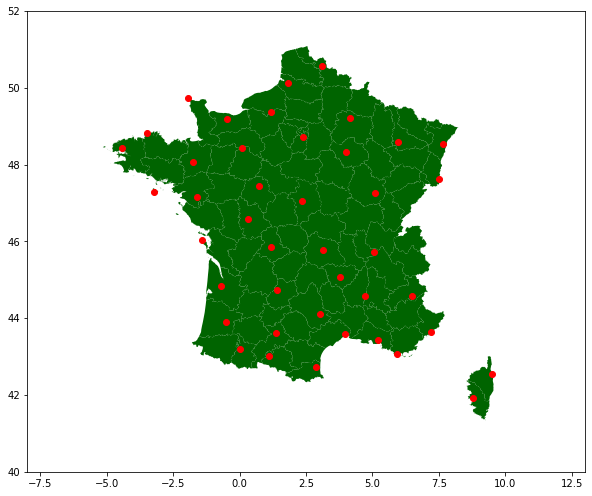

In [136]:
ax = stations_geo.plot(figsize = (10,10), color = 'red', zorder = 2)
fr= communes[communes['dep'] != '97']
fr.dissolve(by='dep').plot(ax = ax, color = 'darkgreen', figsize = (10,10), zorder = 1)
plt.xlim([-8,13])
plt.ylim([40,52])

**Création des tableaux**

In [153]:
df = pd.read_csv('data.csv')
df[['Année']] = df[['Année']].astype(object)
df

C:\Users\theoc\anaconda3\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,3,4,5,6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Départ de feu,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),...,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2006-01-01 00:00:00,4.0,2.0,92.0,5.1
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2006-01-01 03:00:00,3.7,0.0,91.0,4.1
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2006-01-01 06:00:00,3.1,3.0,92.0,5.1
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2006-01-01 09:00:00,4.7,0.6,96.0,3.1
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2006-01-01 12:00:00,6.1,2.0,94.0,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363072,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,0.7,NaN,62.0,28.3
2363073,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-12-31 12:00:00,1.7,NaN,74.0,23.1
2363074,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-12-31 15:00:00,1.0,NaN,78.0,18.0
2363075,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2019-12-31 18:00:00,1.0,NaN,72.0,20.6


In [154]:
df.dtypes

Départ de feu                                  int64
Année                                         object
Date de première alerte                       object
Département                                   object
Commune                                       object
Code postal                                   object
Code INSEE                                    object
Latitude commune                             float64
Longitude commune                            float64
Surface brûlée (m2)                          float64
Surface forêt (m2)                           float64
Surface autres terres boisées (m2)           float64
Surfaces non boisées naturelles (m2)         float64
Surfaces non boisées artificialisées (m2)    float64
Surfaces non boisées (m2)                    float64
Station la plus proche                        object
id_station                                   float64
Latitude station                             float64
Longitude station                            f

In [174]:
df_not_feu = df[df['Départ de feu'] == 0]
df_not_feu = df_not_feu.sort_values(['Date'])
df_not_feu = df_not_feu.reset_index(drop = True)
df_not_feu = df_not_feu.iloc[:,[21,22,23,24]]
df_not_feu

,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,4.0,2.0,92.0,5.1
1,3.7,0.0,92.0,4.1
2,23.5,NaN,95.0,0.0
3,26.1,NaN,93.0,2.1
4,2.8,0.2,91.0,5.1
...,...,...,...,...
2329992,-1.2,0.0,81.0,1.1
2329993,0.8,0.0,87.0,1.0
2329994,27.7,0.0,70.0,3.3
2329995,3.5,0.0,96.0,1.2


In [162]:
df_feu = df[df['Départ de feu'] == 1]
df_feu = df_feu.drop(columns = ['Départ de feu'])
df_feu = df_feu.sort_values(['Date de première alerte'])
df_feu = df_feu.reset_index(drop = True)
df_feu

,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),...,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,2006,2006-01-01 12:50:00,66,SAINT LAURENT DE CERDANS,66260,66179,42.3833,2.61667,10000.0,10000.0,...,PERPIGNAN,7747.0,42.737167,2.872833,42.0,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
1,2006,2006-01-01 12:56:00,66,SALSES LE CHATEAU,66600,66190,42.8328,2.91889,20000.0,0.0,...,PERPIGNAN,7747.0,42.737167,2.872833,42.0,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
2,2006,2006-01-01 15:40:00,83,CALLAS,83830,83028,43.5833,6.53333,30.0,30.0,...,NICE,7690.0,43.648833,7.209000,2.0,2006-01-01 15:00:00,10.4,0.0,76.0,6.2
3,2006,2006-01-02 18:19:00,34,ROUJAN,34320,34237,43.5167,3.30000,37500.0,10000.0,...,MONTPELLIER,7643.0,43.577000,3.963167,2.0,2006-01-02 18:00:00,7.5,0.0,54.0,4.1
4,2006,2006-01-02 20:57:00,83,DRAGUIGNAN,83300,83050,43.5333,6.46667,200.0,200.0,...,NICE,7690.0,43.648833,7.209000,2.0,2006-01-02 21:00:00,6.8,0.0,64.0,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33075,2019,2019-12-27 14:22:00,06,COURSEGOULES,06140,06050,43.8000,7.03333,5000.0,5000.0,...,NICE,7690.0,43.648833,7.209000,2.0,2019-12-27 15:00:00,14.0,0.0,73.0,5.4
33076,2019,2019-12-27 14:53:00,06,UTELLE,06450,06151,43.9167,7.25000,4000.0,4000.0,...,NICE,7690.0,43.648833,7.209000,2.0,2019-12-27 15:00:00,14.0,0.0,73.0,5.4
33077,2019,2019-12-28 17:36:00,40,PHILONDENX,40320,40225,43.5667,-0.45000,5.0,0.0,...,MONT-DE-MARSAN,7607.0,43.909833,-0.500167,59.0,2019-12-28 18:00:00,5.9,0.0,88.0,1.5
33078,2019,2019-12-30 17:05:00,83,COMPS SUR ARTUBY,83840,83044,43.7167,6.50000,500.0,500.0,...,NICE,7690.0,43.648833,7.209000,2.0,2019-12-30 18:00:00,9.5,0.0,80.0,3.6


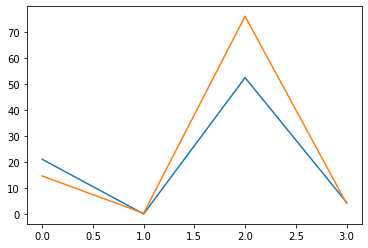

In [222]:
plt.plot(list(df_feu.iloc[:,[20,21,22,23]].mean()))
plt.plot(list(df_not_feu.mean()))

In [223]:
df_correl = df.iloc[:, [0,21,22,23,24]]
df_correl

,Départ de feu,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,0,4.0,2.0,92.0,5.1
1,0,3.7,0.0,91.0,4.1
2,0,3.1,3.0,92.0,5.1
3,0,4.7,0.6,96.0,3.1
4,0,6.1,2.0,94.0,5.1
...,...,...,...,...,...
2363072,0,0.7,NaN,62.0,28.3
2363073,0,1.7,NaN,74.0,23.1
2363074,0,1.0,NaN,78.0,18.0
2363075,0,1.0,NaN,72.0,20.6


<AxesSubplot:xlabel='Départ de feu', ylabel='Température (°C)'>

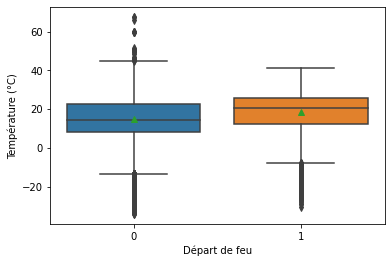

In [224]:
sns.boxplot(x = df_correl['Départ de feu'], y = box['Température (°C)'], showmeans = True)

**Matrices de corrélation (pour l'instant pas ouf, à réfléchir)**

In [163]:
df_feu_correl = df_feu.iloc[:,[8,9,10,11,12,13,20,21,22,23]]
df_feu_correl

,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,10000.0,10000.0,0.0,NaN,NaN,0.0,11.7,0.0,50.0,8.7
1,20000.0,0.0,20000.0,NaN,NaN,0.0,11.7,0.0,50.0,8.7
2,30.0,30.0,0.0,NaN,NaN,0.0,10.4,0.0,76.0,6.2
3,37500.0,10000.0,27500.0,NaN,NaN,0.0,7.5,0.0,54.0,4.1
4,200.0,200.0,0.0,NaN,NaN,0.0,6.8,0.0,64.0,4.1
...,...,...,...,...,...,...,...,...,...,...
33075,5000.0,5000.0,0.0,NaN,NaN,0.0,14.0,0.0,73.0,5.4
33076,4000.0,4000.0,0.0,NaN,NaN,0.0,14.0,0.0,73.0,5.4
33077,5.0,0.0,5.0,NaN,NaN,0.0,5.9,0.0,88.0,1.5
33078,500.0,500.0,0.0,NaN,NaN,0.0,9.5,0.0,80.0,3.6


In [177]:
df_feu_correl.mean()

Surface brûlée (m2)                          34899.828960
Surface forêt (m2)                           16389.866143
Surface autres terres boisées (m2)           15099.307739
Surfaces non boisées naturelles (m2)          5463.305821
Surfaces non boisées artificialisées (m2)     1643.434222
Surfaces non boisées (m2)                     3410.655079
Température (°C)                                21.119288
Précipitations (3 heures)                        0.079135
Humidité (%)                                    52.560059
Vitesse du vent (m/s)                            4.542621
dtype: float64

<AxesSubplot:>

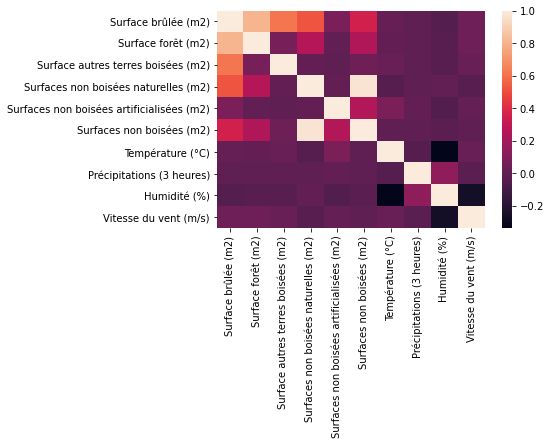

In [167]:
val = df_feu_correl.corr()
sns.heatmap(val)

<AxesSubplot:>

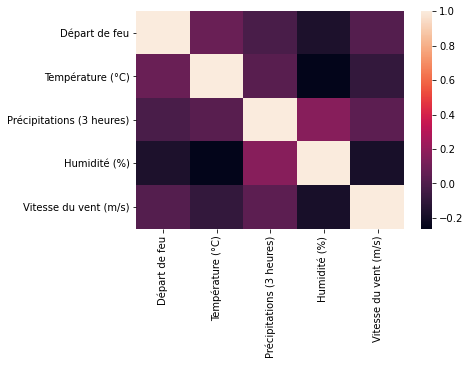

In [168]:
val = df_correl.corr()
sns.heatmap(val)